In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd 
import numpy as np
from scipy import linalg, stats

import matplotlib.pyplot as plt

import mahalanobis as maha

In [3]:
# We used the same number of components for Mahalanobis distance in Covid-Confirm and Covid-Combo
N_COMPONENTS = 18

In [14]:
df_single = pd.read_parquet('data/covid_confirm.parquet')
df_single.drop(columns=['Metadata_Barcode', 'Metadata_Well', 'comp_conc', 'Count_nuclei'], inplace=True)
df_single.rename(columns={'cmpd_conc': 'conc', 'pert_type': 'type'}, inplace=True)
meta_cols_single = [
    'type',
    'batch_id',
    'conc',
    # 'Count_nuclei',
]
df_single.loc[df_single['type'] == 'non-inf', 'type'] = 'uninfected'
df_single.loc[df_single['batch_id'] == 'DMSO', 'type'] = 'infected'
df_single.loc[df_single['type'].isin(['trt', 'poscon']), 'type'] = 'single'

df_combo = pd.read_parquet("data/covid_combo.parquet.gzip")
meta_cols_combo = [
    'type',
    'batch_id_1',
    'conc_1',
    'batch_id_2',
    'conc_2',
]

# Keep only overlapping features
morphology_cols_single = list(set(df_single.columns).difference(set(meta_cols_single)))
morphology_cols_combo = list(set(df_combo.columns).difference(set(meta_cols_combo)))
common_morphology_cols = list(set(morphology_cols_single).intersection(set(morphology_cols_combo)))

print(f"Single: # of morphological features: {len(morphology_cols_single)}")
print(f"Combo: # of morphological features: {len(morphology_cols_combo)}")
print(f"Single + Combo: # of morphological features: {len(common_morphology_cols)}")

df_single = df_single[meta_cols_single + common_morphology_cols]
df_combo = df_combo[meta_cols_combo + common_morphology_cols]

Single: # of morphological features: 1467
Combo: # of morphological features: 2121
Single + Combo: # of morphological features: 1467


In [22]:
df_single_good = df_single[df_single['type'] == 'uninfected'].copy()
df_combo_good = df_combo[df_combo['type'] == 'uninfected'].copy()

# morphological profile of uninfected cells ('good')
x_single_good = df_single_good.drop(columns=meta_cols_single).to_numpy()
x_combo_good = df_combo_good.drop(columns=meta_cols_combo).to_numpy()
x_good = np.concatenate([x_single_good, x_combo_good])

cov_matrix = np.cov(x_good, rowvar=False)
sigma, u = linalg.eigh(cov_matrix, check_finite=True)
rank = min(*x_good.shape) - 1
sigma = sigma[::-1]
# remove values under ~float precision
too_low = len(sigma[sigma>1e-8])
rank = min(rank, too_low)

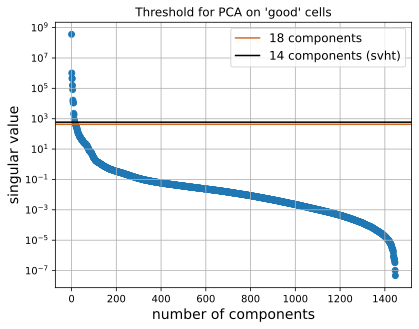

In [24]:
plt.scatter(range(rank), sigma[:rank])

# thresh = sigma[sigma >= 10][-1]
# n_comp = int(np.where(sigma == thresh)[0][0])
# plt.axhline(thresh, c='chocolate', label=f'{n_comp} components')

n_comp = 18
thresh = sigma[n_comp]
plt.axhline(thresh, c='chocolate', label=f'{n_comp} components')

# optimal threshold for the PCA of 'good' cells
thresh = int(maha.svht(x_good))
plt.axhline(sigma[thresh], c='k', label=f'{thresh} components (svht)')

plt.grid()
plt.yscale('log')
plt.legend(fontsize=12)
plt.xlabel('number of components', fontsize=14)
plt.ylabel('singular value', fontsize=14)
plt.title("Threshold for PCA on 'good' cells")
plt.show()

In [33]:
# Omit 'uninfected' from the set for predictions
def get_predictions(df, meta_cols, x_good, n_components):
    df_cells = df[df['type'] != 'uninfected']
    x_cells = df_cells.drop(
        columns=set(meta_cols).intersection(df.columns)
    ).copy()

    dist_pred = maha.get_distance(x_good, x_cells, n_components=n_components)
    df_dist = pd.DataFrame(dist_pred, columns=['distance'])

    proba_pred = maha.get_proba(x_good, x_cells, n_components=n_components)
    df_proba = pd.DataFrame(proba_pred, columns=['proba'])

    predictions = pd.concat(
        [df_cells[meta_cols].reset_index(drop=True), df_dist, df_proba], 
        axis=1
    )
    return predictions

In [35]:
predictions_single = get_predictions(df_single, meta_cols_single, x_good, n_components=12)
predictions_single.head()

,type,batch_id,conc,distance,proba
0,single,BJ1894548,0.3,2.372616,0.933604
1,single,BJ1894765,10.0,2.377693,0.932536
2,single,BJ1896470,10.0,2.374948,0.933115
3,single,BJ1897228,0.1,2.375847,0.932926
4,single,BJ1896003,0.3,2.374528,0.933203


In [36]:
predictions_combo = get_predictions(df_combo, meta_cols_combo, x_good, n_components=12)
predictions_combo.head()

,type,batch_id_1,conc_1,batch_id_2,conc_2,distance,proba
0,combo,BJ1897713,0.83,BJ1894563,0.83,2.819317,0.789138
1,combo,BJ1897713,0.83,BJ1894563,0.83,2.410972,0.925224
2,combo,BJ1897713,0.83,BJ1894563,0.83,2.144410,0.970065
3,combo,BJ1897713,0.83,BJ1894563,0.83,6.173717,0.000147
4,combo,BJ1897713,0.83,BJ1894563,0.83,3.899045,0.230546


In [37]:
def get_averaged_predictions(predictions, meta_cols):
    def quantile(n):
        def quantile_(x):
            return x.quantile(n)
        quantile_.__name__ = f'q_{n*100:.0f}'
        return quantile_

    selected_columns = predictions[meta_cols + ['distance', 'proba']].copy()

    # Aggregate replicates
    average_predictions = selected_columns.groupby(
        by=meta_cols, 
        as_index=False
    ).agg({
        'distance': [quantile(.25), quantile(.75), 'median'],
        'proba': [quantile(.25), quantile(.75), 'median'],
    })

    # Rename columns
    custom_columns = [''.join(col) for col in average_predictions.columns.to_flat_index() if not col[1]]
    custom_columns += ['_'.join(col) for col in average_predictions.columns.to_flat_index() if col[1]]
    average_predictions.columns = custom_columns

    # Quantiles are written as plus/minus to the median
    for metric in ('distance', 'proba'):
        average_predictions[f'{metric}_q_75'] = average_predictions[f'{metric}_q_75'] - average_predictions[f'{metric}_median']
        average_predictions[f'{metric}_q_25'] =  average_predictions[f'{metric}_median'] - average_predictions[f'{metric}_q_25']

    # Sort by distance to non-infected
    average_predictions.sort_values(by=['distance_median'], ascending=True, inplace=True)

    average_predictions.reset_index(inplace=True, drop=True)
    return average_predictions

In [38]:
avg_pred_single = get_averaged_predictions(predictions_single, meta_cols_single)
avg_pred_single.head()

,type,batch_id,conc,distance_q_25,distance_q_75,distance_median,proba_q_25,proba_q_75,proba_median
0,single,BJ1896419,3.333333,0.000427,0.000249,2.369282,0.000052,0.000089,0.934300
1,single,176272344,0.833333,0.000000,0.000000,2.369918,0.000000,0.000000,0.934167
2,single,BJ1898164,30.000000,0.000965,0.001339,2.370060,0.000279,0.000200,0.934138
3,single,BJ1898873,0.833333,0.000073,0.001629,2.370135,0.000340,0.000015,0.934122
4,single,BA1041753,10.000000,0.000000,0.000000,2.370683,0.000000,0.000000,0.934008


In [39]:
avg_pred_combo = get_averaged_predictions(predictions_combo, meta_cols_combo)
avg_pred_combo.head()

,type,batch_id_1,conc_1,batch_id_2,conc_2,distance_q_25,distance_q_75,distance_median,proba_q_25,proba_q_75,proba_median
0,combo,BJ1896888,10.00,BJ1898106,10.00,0.208537,0.185672,2.208273,0.032946,0.021477,0.961978
1,combo,BJ1898404,3.33,BJ1897775,0.83,0.377521,0.721695,2.240631,0.235306,0.033911,0.957293
2,combo,BJ1894268,3.33,BJ1897249,3.33,0.048095,0.344720,2.352261,0.098759,0.009080,0.937767
3,combo,BJ1898352,3.33,BJ1897249,10.00,0.186697,0.309088,2.382461,0.090474,0.032160,0.931521
4,combo,BJ1898849,3.33,BJ1894762,3.33,0.163392,0.681919,2.412192,0.271626,0.031099,0.924945
